# Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import seaborn as sns
from scipy import stats

# Data Pipeline

In [2]:
# Reading preprocessed sales data using pandas
sales_df = pd.read_csv('HELM/Sales_Final_Output.csv')

In [3]:
sales_df.head()

,BUCode,Segmentation,VIN first 11,Vin next 6,VIN,PlanType,SOW_PlanType,PSOW_PWPID,plancode,salesdate,...,PlanCategory,Description,Average Price,Revenue_Per_VIN,VIN1_Car_Built,VIN23_Manufacturer,VIN48_Brand_Engine_Type,VIN238_Flex_Fuel,VIN10_Model_Year,VIN11_Assembly
0,45026,F2F,19UDE2F73HA,227848,19UDE2F73HA227848,S,OTHER,LOF,ECPSR34N,2022-10-06,...,LOF,Essential Care Platinum w/ Rot.-Synthetic Gas,153.67,153.67,1,9U,DE2F7,9U7,H,A
1,45026,F2F,19XFB2F54CE,813127,19XFB2F54CE813127,S,OTHER,LOF,ECPS23N,2022-10-20,...,LOF,ESSENTIAL CARE PLATINUM - 2 YEARS / 3 OIL CHAN...,153.67,153.67,1,9X,FB2F5,9X5,C,E
2,45026,F2F,1C3CDFBB7GD,460433,1C3CDFBB7GD460433,S,OTHER,LOF,ECPSR34N,2022-10-05,...,LOF,Essential Care Platinum w/ Rot.-Synthetic Gas,153.67,153.67,1,C3,CDFBB,C3B,G,D
3,45026,F2F,1C4BJWDG0EL,534154,1C4BJWDG0EL534154,S,OTHER,LOF,ECGR34N,2022-12-19,...,LOF,Essential Care Gold w/ Rot.-Synthetic Blend,153.67,153.67,1,C4,BJWDG,C4G,E,L
4,45026,F2F,1C4BJWDG9HL,585361,1C4BJWDG9HL585361,S,OTHER,LOF,ECGR34N,2022-12-21,...,LOF,Essential Care Gold w/ Rot.-Synthetic Blend,153.67,153.67,1,C4,BJWDG,C4G,H,L


In [4]:
sales_df.columns

Index(['BUCode', 'Segmentation', 'VIN first 11', 'Vin next 6', 'VIN',
       'PlanType', 'SOW_PlanType', 'PSOW_PWPID', 'plancode', 'salesdate',
       'ContractCnt', 'SaleSource', 'Dealer Code', 'Group Flag', 'State',
       'Zip Code', 'Dealer Map Lattitude', 'Dealer Map Longitude',
       'Sales Group Size', 'Consolidated Franchise Code', 'Appointment Date',
       'Territory', 'BCName', 'PlanCategory', 'Description', 'Average Price',
       'Revenue_Per_VIN', 'VIN1_Car_Built', 'VIN23_Manufacturer',
       'VIN48_Brand_Engine_Type', 'VIN238_Flex_Fuel', 'VIN10_Model_Year',
       'VIN11_Assembly'],
      dtype='object')

In [5]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215932 entries, 0 to 215931
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   BUCode                       215932 non-null  int64  
 1   Segmentation                 215932 non-null  object 
 2   VIN first 11                 215932 non-null  object 
 3   Vin next 6                   215932 non-null  int64  
 4   VIN                          215932 non-null  object 
 5   PlanType                     215932 non-null  object 
 6   SOW_PlanType                 215932 non-null  object 
 7   PSOW_PWPID                   215932 non-null  object 
 8   plancode                     215932 non-null  object 
 9   salesdate                    215932 non-null  object 
 10  ContractCnt                  215932 non-null  int64  
 11  SaleSource                   215932 non-null  object 
 12  Dealer Code                  215932 non-null  int64  
 13 

In [6]:
sales_df['PlanCategory'].value_counts()

LOF                        75771
CPOV Base Warranties       55194
New Majors Stated Time     25096
Used Majors Stated Time    19945
Gap                        11908
Multicare                   6764
Exclude                     6381
Owner Care                  6301
Short Term Lease            1951
Tire & Wheel                1852
Lease Wear & Tear           1590
Limited Warranties          1378
New Majors Unlimited         867
Auto Appearance Care         504
Used Majors Unlimited        430
Name: PlanCategory, dtype: int64

# Correlation on Franchise Code and Plan Category w.r.t Contract Count

In [7]:
# Creating a pivot table on Franchise COde and Plan Category on the Contract Count
contract_cnt_pivot = sales_df.pivot_table('ContractCnt', ['Consolidated Franchise Code', 'PlanCategory'], aggfunc='sum').reset_index()
display(contract_cnt_pivot)

,Consolidated Franchise Code,PlanCategory,ContractCnt
0,CDTJR,Auto Appearance Care,233
1,CDTJR,CPOV Base Warranties,41748
2,CDTJR,Exclude,4818
3,CDTJR,Gap,8025
4,CDTJR,LOF,57894
...,...,...,...
147,Y,Owner Care,95
148,Y,Short Term Lease,10
149,Y,Tire & Wheel,190
150,Y,Used Majors Stated Time,167


In [8]:
# Creating the correlation matrix using the above created pivot table
Franchise_PlanCat_corr_df = pd.DataFrame(index=contract_cnt_pivot['PlanCategory'].unique(), columns=contract_cnt_pivot['Consolidated Franchise Code'].unique())
for tup in contract_cnt_pivot.itertuples(index=False):
    Franchise_PlanCat_corr_df.loc[tup[1], tup[0]] = tup[2]
Franchise_PlanCat_corr_df = Franchise_PlanCat_corr_df.fillna(0)
Franchise_PlanCat_corr_df

,CDTJR,CDTJXR,CDTR,CDTXR,CJ,CJX,DTJR,DTR,DTXR,J,X,XY,Y
Auto Appearance Care,233,217,21,0,5,0,0,10,0,0,0,10,8
CPOV Base Warranties,41748,9016,289,20,1645,162,2,920,412,342,0,426,212
Exclude,4818,1025,36,1,79,13,2,254,8,35,0,47,63
Gap,8025,2661,4,9,707,7,0,278,8,4,0,95,110
LOF,57894,12469,296,17,2581,38,291,1511,73,452,0,111,38
Lease Wear & Tear,1172,256,1,1,115,0,0,24,0,3,0,13,5
Limited Warranties,1119,158,17,2,54,7,0,14,1,4,0,2,0
Multicare,4451,1079,0,2,534,0,0,275,8,7,0,205,203
New Majors Stated Time,18789,3947,537,13,736,38,4,507,41,227,0,165,92
New Majors Unlimited,678,119,33,0,7,0,0,20,1,8,0,1,0


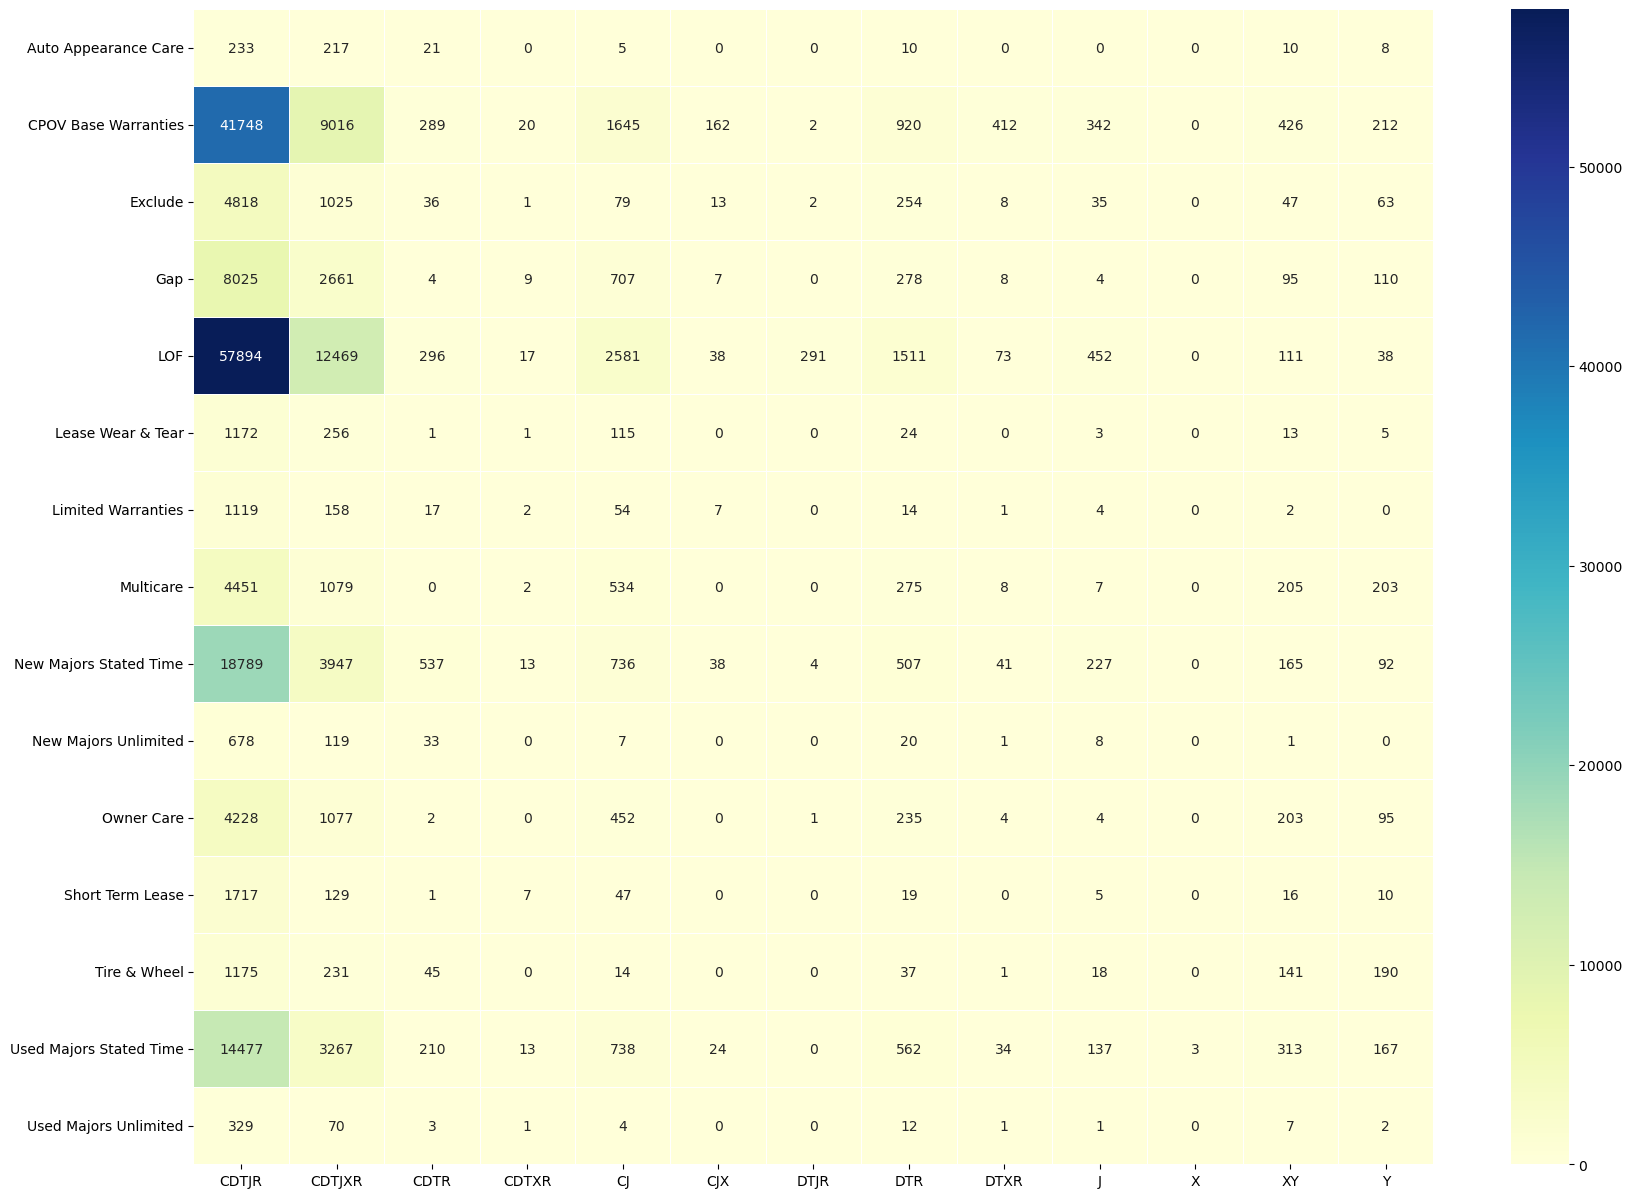

In [9]:
# Plotted the heatmap using the above created correlation matrix.
fig, ax = plt.subplots(figsize=(20,15))
dataplot = sns.heatmap(Franchise_PlanCat_corr_df, cmap="YlGnBu", annot=True, linewidths=.5, ax=ax, fmt='g')
plt.show()

# Correlation on Franchise Code and Plan Category w.r.t Average Price

In [10]:
# Creating a pivot table on Franchise COde and Plan Category on the Average Price
avg_price_pivot = sales_df.pivot_table('Average Price', ['Consolidated Franchise Code', 'PlanCategory'], aggfunc='sum').reset_index()
display(avg_price_pivot)

,Consolidated Franchise Code,PlanCategory,Average Price
0,CDTJR,Auto Appearance Care,60582.33
1,CDTJR,CPOV Base Warranties,17585927.52
2,CDTJR,Exclude,130423.26
3,CDTJR,Gap,2938755.00
4,CDTJR,LOF,8896570.98
...,...,...,...
147,Y,Owner Care,51544.15
148,Y,Short Term Lease,2430.40
149,Y,Tire & Wheel,44604.40
150,Y,Used Majors Stated Time,257485.61


In [11]:
# Creating correlation matrix using the above created pivot table
Franchise_PlanCat_avg_price_corr_df = pd.DataFrame(index=avg_price_pivot['PlanCategory'].unique(), columns=avg_price_pivot['Consolidated Franchise Code'].unique())
for tup in avg_price_pivot.itertuples(index=False):
    Franchise_PlanCat_avg_price_corr_df.loc[tup[1], tup[0]] = tup[2]
Franchise_PlanCat_avg_price_corr_df = Franchise_PlanCat_avg_price_corr_df.fillna(0)
Franchise_PlanCat_avg_price_corr_df

,CDTJR,CDTJXR,CDTR,CDTXR,CJ,CJX,DTJR,DTR,DTXR,J,X,XY,Y
Auto Appearance Care,60582.33,56422.17,5460.21,0.00,1300.05,0.00,0.00,2600.10,0.00,0.00,0.00,2600.10,2080.08
CPOV Base Warranties,17585927.52,3797899.84,121738.36,8424.80,692939.80,68240.88,842.48,387540.80,173550.88,144064.08,0.00,179448.24,89302.88
Exclude,130423.26,27746.75,974.52,27.07,2138.53,351.91,54.14,6875.78,216.56,947.45,0.00,1272.29,1705.41
Gap,2938755.00,974458.20,1464.80,3295.80,258903.40,2563.40,0.00,101803.60,2929.60,1464.80,0.00,34789.00,40282.00
LOF,8896570.98,1916111.23,45486.32,2612.39,396622.27,5839.46,44717.97,232195.37,11217.91,69458.84,0.00,17057.37,5839.46
Lease Wear & Tear,526345.20,114969.60,449.10,449.10,51646.50,0.00,0.00,10778.40,0.00,1347.30,0.00,5838.30,2245.50
Limited Warranties,216940.53,30631.46,3295.79,387.74,10468.98,1357.09,0.00,2714.18,193.87,775.48,0.00,387.74,0.00
Multicare,1753783.02,425147.58,0.00,788.04,210406.68,0.00,0.00,108355.50,3152.16,2758.14,0.00,80774.10,79986.06
New Majors Stated Time,26831819.34,5636552.82,766868.22,18564.78,1051052.16,54266.28,5712.24,724026.42,58550.46,324169.62,0.00,235629.90,131381.52
New Majors Unlimited,1785350.28,313357.94,86897.58,0.00,18432.82,0.00,0.00,52665.20,2633.26,21066.08,0.00,2633.26,0.00


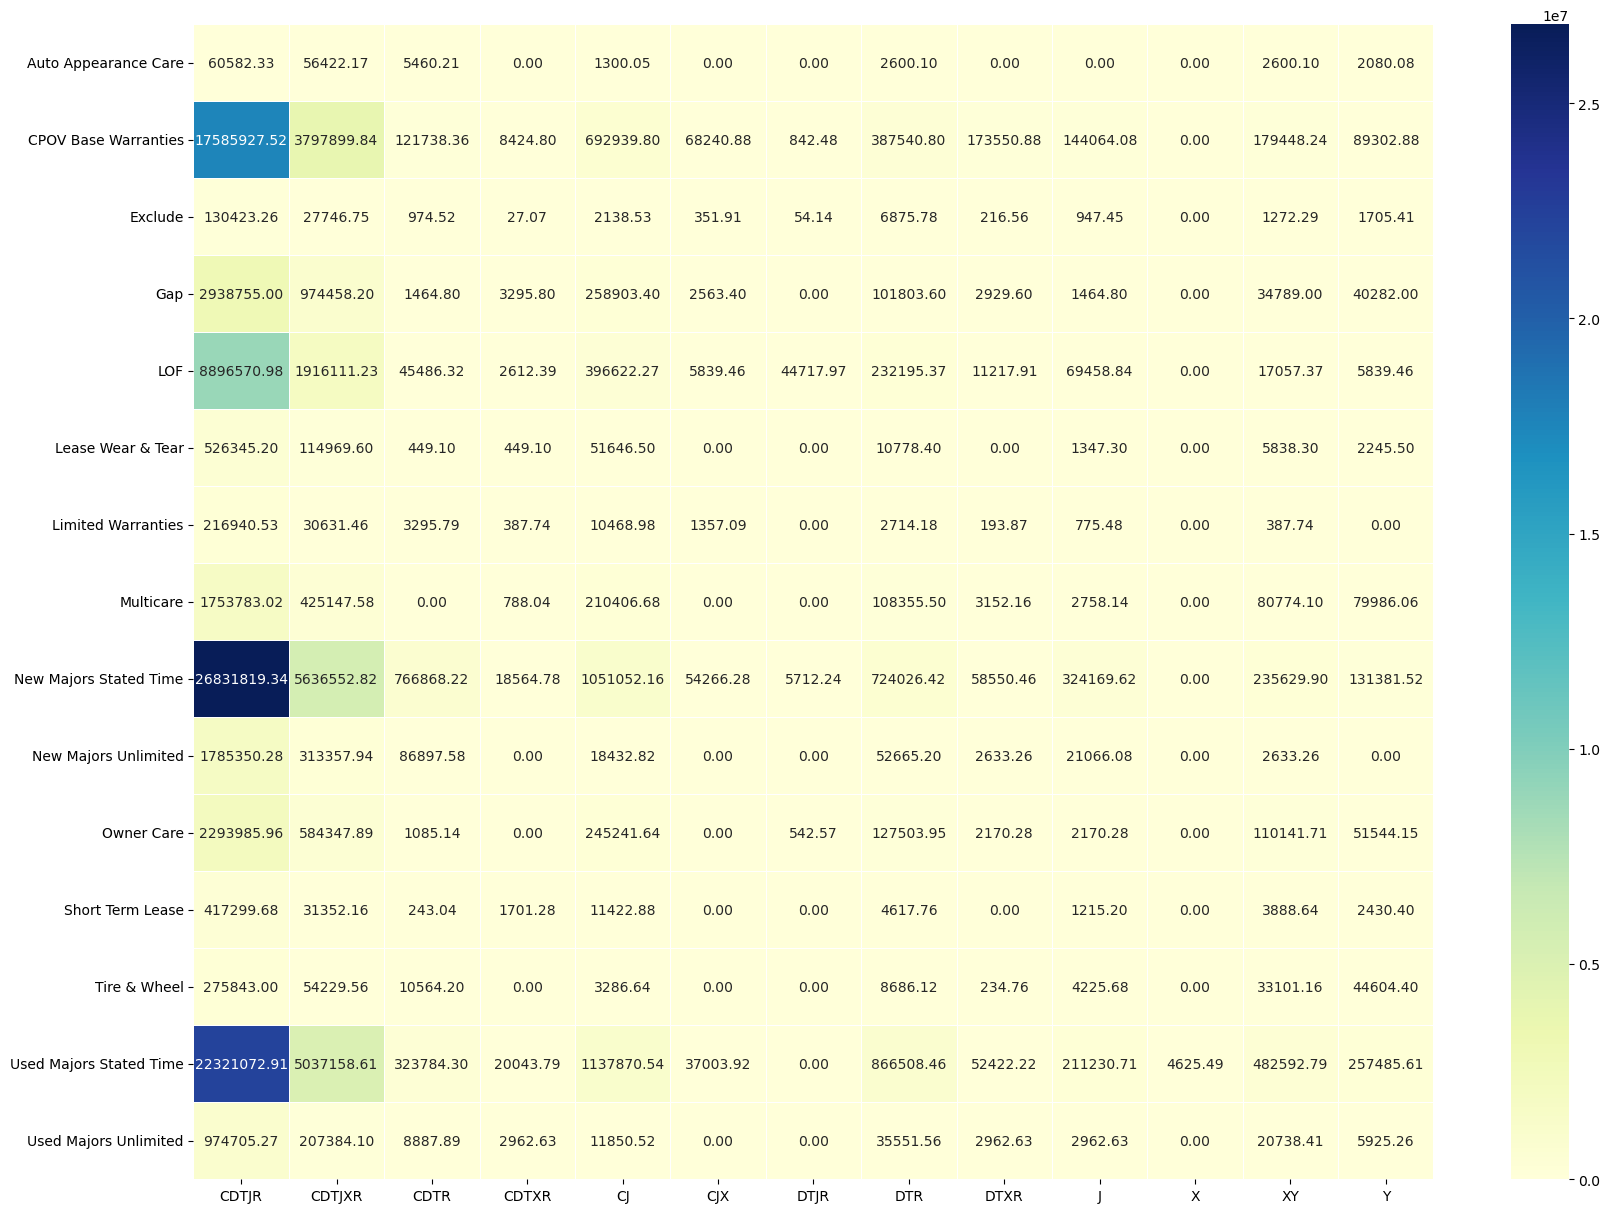

In [12]:
# Plotting the heat map using the above created correlation matrix
fig, ax = plt.subplots(figsize=(20,15))
dataplot = sns.heatmap(Franchise_PlanCat_avg_price_corr_df, cmap="YlGnBu", annot=True, linewidths=.5, ax=ax, fmt='.2f')
plt.show()

In [13]:
# Filtering the sales_df data by picking selective columns
filtered_sales_df = sales_df[['Segmentation', 'PlanType', 'VIN1_Car_Built', 'VIN23_Manufacturer', 'VIN48_Brand_Engine_Type', \
'VIN238_Flex_Fuel', 'VIN10_Model_Year', 'VIN11_Assembly', 'plancode', 'SaleSource', 'Dealer Code', \
'Group Flag', 'State', 'Sales Group Size', 'Consolidated Franchise Code', 'Territory', 'BCName', \
'PlanCategory']] # SELECTION OF REQUIRED FEATURES MANUALLY

In [14]:
filtered_sales_df

,Segmentation,PlanType,VIN1_Car_Built,VIN23_Manufacturer,VIN48_Brand_Engine_Type,VIN238_Flex_Fuel,VIN10_Model_Year,VIN11_Assembly,plancode,SaleSource,Dealer Code,Group Flag,State,Sales Group Size,Consolidated Franchise Code,Territory,BCName,PlanCategory
0,F2F,S,1,9U,DE2F7,9U7,H,A,ECPSR34N,SVL,45026,No Group,NC,C,CDTJR,SE01,Southeast,LOF
1,F2F,S,1,9X,FB2F5,9X5,C,E,ECPS23N,SVL,45026,No Group,NC,C,CDTJR,SE01,Southeast,LOF
2,F2F,S,1,C3,CDFBB,C3B,G,D,ECPSR34N,SVL,45026,No Group,NC,C,CDTJR,SE01,Southeast,LOF
3,F2F,S,1,C4,BJWDG,C4G,E,L,ECGR34N,SVL,45026,No Group,NC,C,CDTJR,SE01,Southeast,LOF
4,F2F,S,1,C4,BJWDG,C4G,H,L,ECGR34N,SVL,45026,No Group,NC,C,CDTJR,SE01,Southeast,LOF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215927,BDT,S,Z,AS,PAKBN,ASN,N,7,ARMAINT440,FIN,69402,No Group,NY,A,Y,PNE1,Northeast,Owner Care
215928,BDT,N,Z,AS,PAKBN,ASN,P,7,ARM7100,FIN,69215,No Group,TN,A,XY,PSE1,Southeast,New Majors Stated Time
215929,BDT,U,Z,AS,PAKBN,ASN,L,7,UM5602N,TDM,69388,No Group,IL,A,XY,PMW1,MidWest,Used Majors Stated Time
215930,BDT,U,Z,FB,ERFAB,FBB,J,6,XAP2UNL5N,TDM,45715,No Group,RI,C,CDTJR,PNE1,Northeast,Used Majors Stated Time


In [15]:
# Changing Data Type of each column to string
filtered_sales_df = filtered_sales_df.applymap(str)

In [16]:
# Encoding Categorical Columns
col_encoders = {}
for col in filtered_sales_df.columns:
    label_encoder = LabelEncoder()
    filtered_sales_df[col] = label_encoder.fit_transform(filtered_sales_df[col])
    col_encoders[col] = label_encoder

In [17]:
filtered_sales_df['Average Price'] = sales_df['Average Price']

In [18]:
filtered_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215932 entries, 0 to 215931
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Segmentation                 215932 non-null  int32  
 1   PlanType                     215932 non-null  int32  
 2   VIN1_Car_Built               215932 non-null  int32  
 3   VIN23_Manufacturer           215932 non-null  int32  
 4   VIN48_Brand_Engine_Type      215932 non-null  int32  
 5   VIN238_Flex_Fuel             215932 non-null  int32  
 6   VIN10_Model_Year             215932 non-null  int32  
 7   VIN11_Assembly               215932 non-null  int32  
 8   plancode                     215932 non-null  int32  
 9   SaleSource                   215932 non-null  int32  
 10  Dealer Code                  215932 non-null  int32  
 11  Group Flag                   215932 non-null  int32  
 12  State                        215932 non-null  int32  
 13 

In [19]:
filtered_sales_df.corr()

,Segmentation,PlanType,VIN1_Car_Built,VIN23_Manufacturer,VIN48_Brand_Engine_Type,VIN238_Flex_Fuel,VIN10_Model_Year,VIN11_Assembly,plancode,SaleSource,Dealer Code,Group Flag,State,Sales Group Size,Consolidated Franchise Code,Territory,BCName,PlanCategory,Average Price
Segmentation,1.000000,-0.118983,-0.018383,0.041904,-0.003126,0.040599,0.118654,-0.016950,0.205405,-0.196704,0.043765,0.038536,0.005318,0.193436,0.004112,-0.137190,-0.038943,0.208635,0.190012
PlanType,-0.118983,1.000000,0.015400,-0.022046,-0.023841,-0.022278,-0.192940,0.021427,-0.469851,-0.248378,-0.007603,-0.028696,0.006594,0.019909,0.006850,0.014436,0.008128,-0.265555,-0.128698
VIN1_Car_Built,-0.018383,0.015400,1.000000,0.030658,-0.187582,0.048005,-0.010893,-0.096606,-0.000718,-0.043535,0.077096,0.001719,0.008572,-0.084539,0.278658,0.015972,-0.000555,0.040601,0.017898
VIN23_Manufacturer,0.041904,-0.022046,0.030658,1.000000,-0.152486,0.991248,-0.144530,-0.087616,0.089653,-0.020770,0.000547,-0.012519,0.045245,-0.042585,0.000875,0.044280,0.045002,0.107677,0.029926
VIN48_Brand_Engine_Type,-0.003126,-0.023841,-0.187582,-0.152486,1.000000,-0.132068,0.156757,-0.019071,-0.032404,-0.010248,-0.002062,0.039706,0.023018,-0.003592,-0.056119,-0.047747,-0.041231,-0.031365,0.003703
VIN238_Flex_Fuel,0.040599,-0.022278,0.048005,0.991248,-0.132068,1.000000,-0.152065,-0.083196,0.090996,-0.020367,0.002432,-0.009495,0.047943,-0.052340,0.007002,0.045330,0.044828,0.110898,0.031853
VIN10_Model_Year,0.118654,-0.192940,-0.010893,-0.144530,0.156757,-0.152065,1.000000,-0.012888,0.168646,-0.346824,0.014659,-0.013428,0.021842,0.069958,0.027427,0.000594,0.021226,0.086978,0.202374
VIN11_Assembly,-0.016950,0.021427,-0.096606,-0.087616,-0.019071,-0.083196,-0.012888,1.000000,-0.022191,0.035711,-0.033475,-0.012300,-0.021989,0.017375,-0.108812,0.002441,-0.003167,-0.051089,-0.027637
plancode,0.205405,-0.469851,-0.000718,0.089653,-0.032404,0.090996,0.168646,-0.022191,1.000000,-0.098854,0.036702,0.022280,0.012783,-0.051154,0.022272,-0.028460,-0.004761,0.658330,0.680518
SaleSource,-0.196704,-0.248378,-0.043535,-0.020770,-0.010248,-0.020367,-0.346824,0.035711,-0.098854,1.000000,-0.042029,0.019535,-0.069779,-0.050616,-0.054059,0.038265,-0.002171,-0.017526,-0.302445


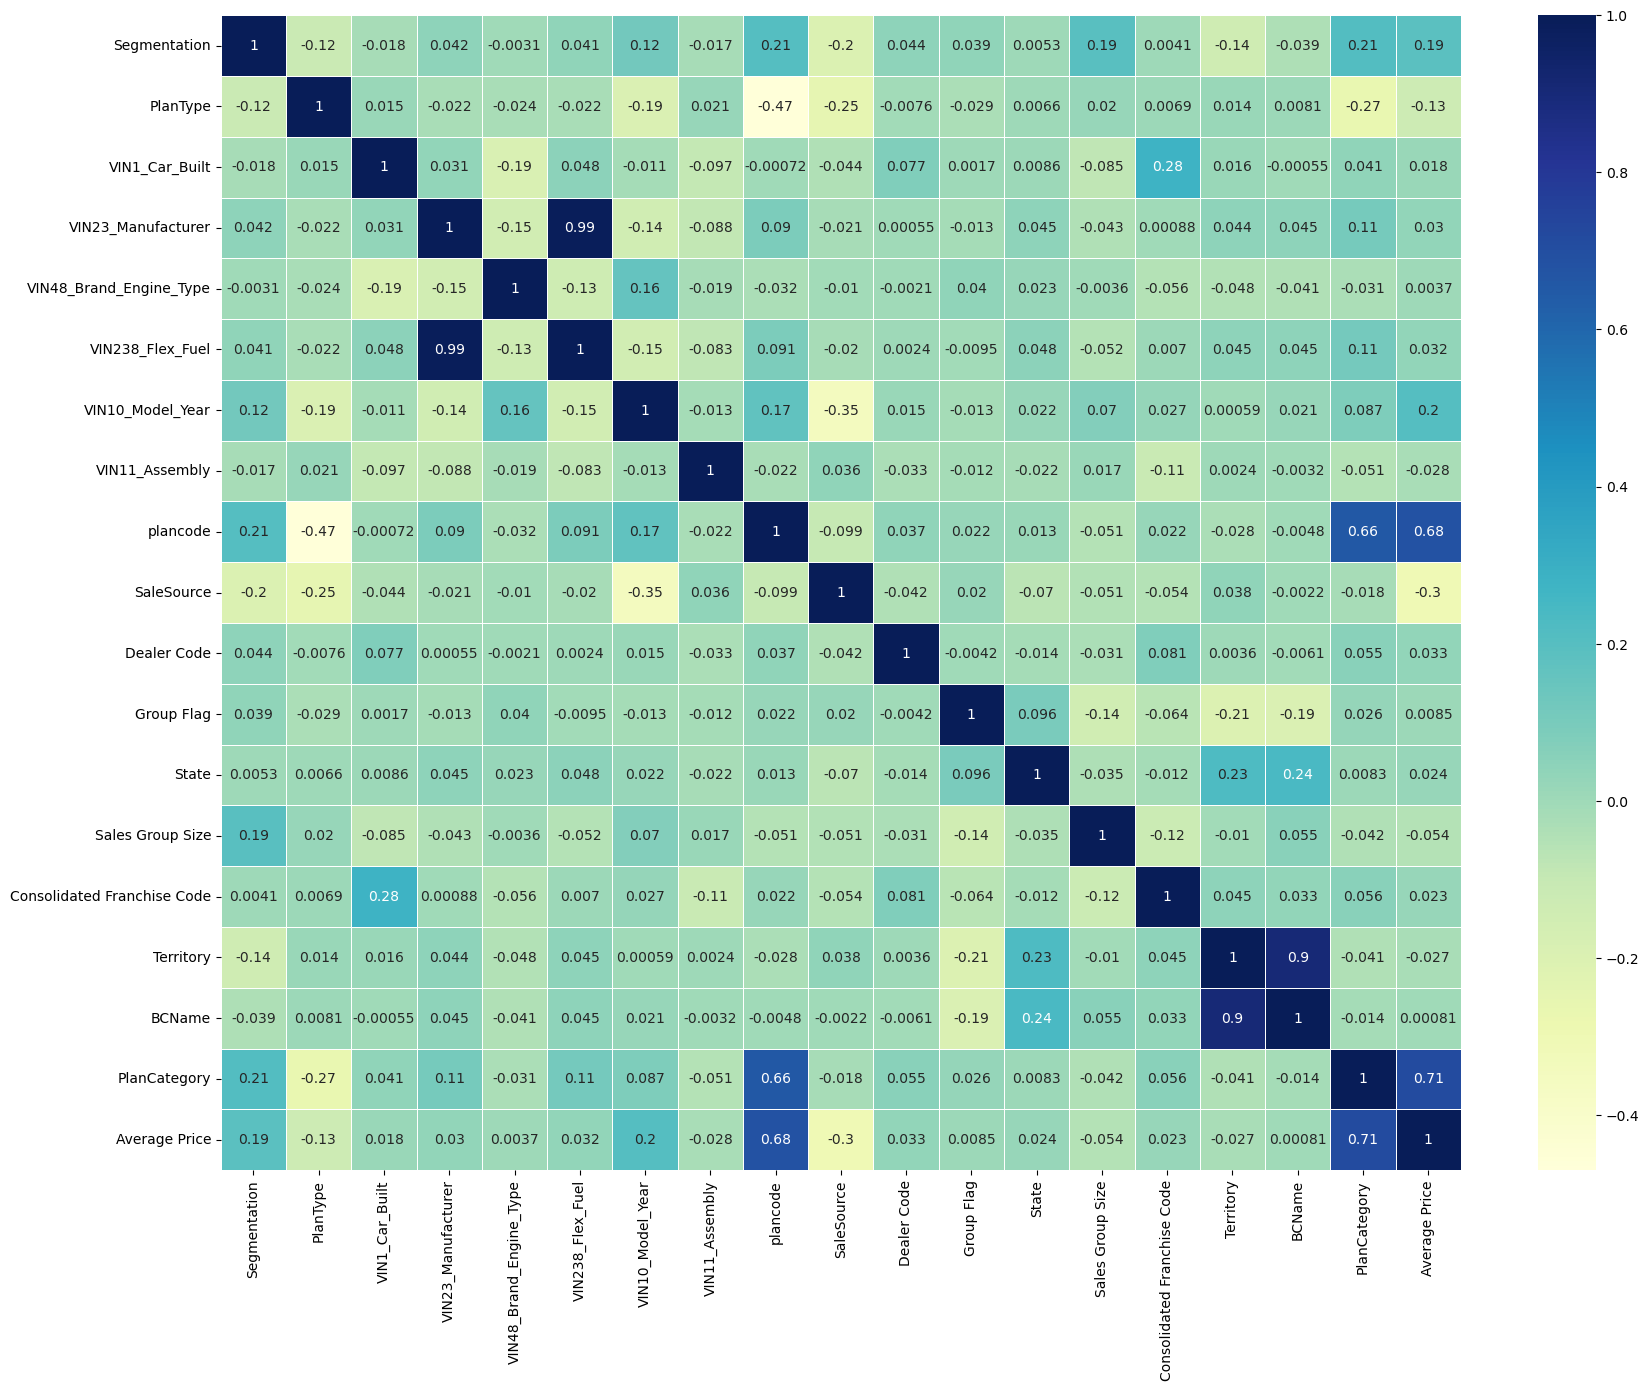

In [20]:
fig, ax = plt.subplots(figsize=(20,15))         # Sample figsize in inches
dataplot = sns.heatmap(filtered_sales_df.corr(), cmap="YlGnBu", annot=True, linewidths=.5, ax=ax)
  
# displaying heatmap
plt.show()

In [21]:
linear_model = LinearRegression()

In [22]:
# R-Sqaured Values for Each Fold in Cross Validation
scores = cross_val_score(linear_model, filtered_sales_df.iloc[:,:-1], filtered_sales_df['Average Price'], scoring='r2', cv=10)
scores    

array([0.6888842 , 0.73405147, 0.69556594, 0.66254838, 0.71494669,
       0.65977341, 0.65792361, 0.66807136, 0.60907113, 0.59508856])

In [23]:
# Implementing Cross_Validation in an explicit way
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
scores = cross_val_score(linear_model, filtered_sales_df.iloc[:,:-1], filtered_sales_df['Average Price'], scoring='r2', cv=folds)
scores   

array([0.67622086, 0.67414231, 0.68133965, 0.67501197, 0.67331321,
       0.67098773, 0.68594396, 0.67091976, 0.67267668, 0.67427185])

In [24]:
# Cross Validation with Grid Search CV on Linear Regression
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

hyper_params = [{'n_features_to_select': list(range(1, 19))}]


lm = LinearRegression()
lm.fit(filtered_sales_df.iloc[:,:-1], filtered_sales_df['Average Price'])
rfe = RFE(lm)             

# Created Grid Search for implementing models whcih uses all possible combinations of features
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# Training the Linear Regression model using the sales data
model_cv.fit(filtered_sales_df.iloc[:,:-1], filtered_sales_df['Average Price'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18]}],
             return_train_score=True, scoring='r2', verbose=1)

In [25]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.153529,0.027928,0.004341,0.000527,1,{'n_features_to_select': 1},0.097007,0.088464,0.092773,0.090291,...,0.091395,0.003223,18,0.090061,0.092190,0.091142,0.091755,0.092226,0.091475,0.000808
1,1.207043,0.070344,0.005240,0.000664,2,{'n_features_to_select': 2},0.598010,0.597166,0.591697,0.594795,...,0.593858,0.003810,17,0.592834,0.593071,0.594423,0.593640,0.595437,0.593881,0.000952
2,1.353237,0.122304,0.005436,0.000787,3,{'n_features_to_select': 3},0.599331,0.598417,0.593470,0.596215,...,0.595345,0.003639,16,0.594368,0.594621,0.595844,0.595150,0.596884,0.595373,0.000909
3,1.193089,0.072259,0.005884,0.000980,4,{'n_features_to_select': 4},0.600775,0.599334,0.595320,0.597196,...,0.596726,0.003409,15,0.595751,0.596131,0.597122,0.596648,0.598199,0.596770,0.000852
4,1.291311,0.102563,0.005871,0.000460,5,{'n_features_to_select': 5},0.602659,0.601284,0.597585,0.599170,...,0.598821,0.003217,14,0.597901,0.598264,0.599177,0.598777,0.600220,0.598868,0.000804
5,1.182870,0.088489,0.007059,0.001816,6,{'n_features_to_select': 6},0.602726,0.601337,0.597646,0.599277,...,0.598900,0.003204,13,0.597985,0.598350,0.599262,0.598850,0.600293,0.598948,0.000800
6,1.201122,0.097804,0.007202,0.000953,7,{'n_features_to_select': 7},0.602932,0.601594,0.597662,0.599422,...,0.599062,0.003232,12,0.598130,0.598621,0.599453,0.599148,0.600443,0.599159,0.000785
7,1.043759,0.039481,0.029548,0.046234,8,{'n_features_to_select': 8},0.602927,0.601677,0.597664,0.599678,...,0.599128,0.003252,11,0.598130,0.598793,0.599453,0.599275,0.600445,0.599219,0.000765
8,1.020656,0.045435,0.007507,0.002368,9,{'n_features_to_select': 9},0.605256,0.601664,0.599958,0.599672,...,0.600508,0.003009,10,0.600456,0.598796,0.601787,0.599277,0.602779,0.600619,0.001495
9,0.942596,0.058541,0.007425,0.000562,10,{'n_features_to_select': 10},0.674426,0.604276,0.671593,0.601700,...,0.644951,0.034284,9,0.674978,0.601009,0.675686,0.601636,0.675394,0.645741,0.036268


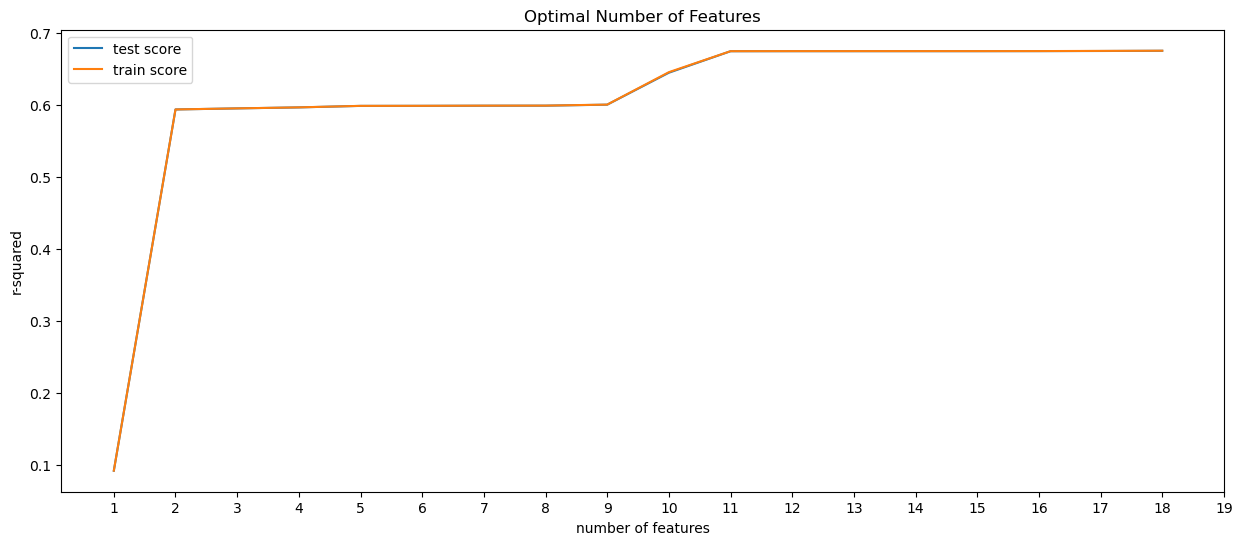

In [26]:
plt.figure(figsize=(15,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')
yint = range(1, 20)
plt.xticks(yint)
plt.show()

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(filtered_sales_df.iloc[:,:-1], filtered_sales_df['Average Price'], test_size=0.3, random_state=1)

In [29]:
n_features_optimal = 10

lm = LinearRegression()
lm.fit(X_train, y_train)

# RFE decided which 10 features are optimal for model buidling
rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(filtered_sales_df.iloc[:,:-1], filtered_sales_df['Average Price'])

# predict prices of X_test
# y_pred = lm.predict(X_test)
y_pred = rfe.predict(X_test)



In [30]:
rfe.feature_names_in_[rfe.ranking_ == 1]# P-VALUE TO GET SIGNIFICANT FEATURE

array(['Segmentation', 'PlanType', 'VIN1_Car_Built', 'VIN23_Manufacturer',
       'VIN10_Model_Year', 'SaleSource', 'Sales Group Size',
       'Consolidated Franchise Code', 'BCName', 'PlanCategory'],
      dtype=object)

In [31]:
# Getting the important features from RFE Ranking
X = X_train[rfe.feature_names_in_[rfe.ranking_ == 1]]

In [32]:
from sklearn.feature_selection import f_regression

In [33]:
# Computing the P-Values for X
scores, pvalues = f_regression(X, y_train.astype('int'))

In [34]:
# Printing the p-values for each column
for col, p_val in zip(X.columns, pvalues):
    print(f'{col} - {p_val}')

Segmentation - 0.0
PlanType - 0.0
VIN1_Car_Built - 6.036270604197276e-15
VIN23_Manufacturer - 1.0507305520100704e-24
VIN10_Model_Year - 0.0
SaleSource - 0.0
Sales Group Size - 1.1838143918506121e-94
Consolidated Franchise Code - 2.242742334775255e-21
BCName - 0.6872113924319383
PlanCategory - 0.0


In [35]:
# Computing the P-Values for X
scores, pvalues = f_regression(X_train, y_train.astype('int'))

In [36]:
# Printing the p-values for each column
for col, p_val in zip(X_train.columns, pvalues):
    print(f'{col} - {p_val}')

Segmentation - 0.0
PlanType - 0.0
VIN1_Car_Built - 6.036270604197276e-15
VIN23_Manufacturer - 1.0507305520100704e-24
VIN48_Brand_Engine_Type - 0.43128775167719835
VIN238_Flex_Fuel - 5.209135655093117e-28
VIN10_Model_Year - 0.0
VIN11_Assembly - 1.0520579014535607e-24
plancode - 0.0
SaleSource - 0.0
Dealer Code - 9.975095108971083e-35
Group Flag - 5.109618634273107e-05
State - 2.9050557215259032e-21
Sales Group Size - 1.1838143918506121e-94
Consolidated Franchise Code - 2.242742334775255e-21
Territory - 1.0732361337554638e-28
BCName - 0.6872113924319383
PlanCategory - 0.0


# Evaluating Linear Regression Model

In [37]:
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score - {r2}')

# MAE varies from the scale of target variable. lower the MAE the better the model is
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error - {mae}')
print('-'*40)
print(f'Maximum price in the data set is {y_train.max()}')

R^2 Score - 0.6030644289145184
Mean Absolute Error - 241.93946809893743
----------------------------------------
Maximum price in the data set is 2962.63


# Support Vector Regression Model

In [38]:
from sklearn.svm import LinearSVR

## K-Fold Cross Validation

In [39]:
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)

In [40]:
# Building Support Vector Regression Model using the K-Fold Cross validation data.
clf = SVR(kernel='linear')
scores = cross_val_score(linear_model, filtered_sales_df.iloc[:,:-1], filtered_sales_df['Average Price'], scoring='r2', cv=folds)
scores

array([0.67622086, 0.67414231, 0.68133965, 0.67501197, 0.67331321,
       0.67098773, 0.68594396, 0.67091976, 0.67267668, 0.67427185])

In [ ]:
# Building Support Vector Regression Model using the K-Fold Cross validation and Grid Search CV.

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

hyper_params = [{'n_features_to_select': list(range(1, 19))}]


lm = SVR()
lm.fit(filtered_sales_df.iloc[:,:-1], filtered_sales_df['Average Price'])
rfe = RFE(lm)             

model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

model_cv.fit(filtered_sales_df.iloc[:,:-1], filtered_sales_df['Average Price'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [ ]:
# Model Training
model = LinearSVR().fit(X_train, y_train)

In [ ]:
# Predictions on test data
y_pred = model.predict(X_test)

### Performance Evaluations of SVM Model

In [ ]:
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score - {r2}')

# MAE varies from the scale of target variable. lower the MAE the better the model is
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error - {mae}')
print('-'*40)
print(f'Maximum price in the data set is {y_train.max()}')

# Random Forest Regression Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(filtered_sales_df.iloc[:,:-1], filtered_sales_df['Average Price'], test_size=0.3, random_state=1)

In [ ]:
# Created Random Forest Regression Model instance
rf_reg = RandomForestRegressor()

In [ ]:
# Training the RF Model on train set
rf_reg.fit(X_train, y_train)

In [ ]:
# Testing the Model on test set
y_pred = rf_reg.predict(X_test)

### Performance Evaluation of RF Model

In [ ]:
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score - {r2}')

# MAE varies from the scale of target variable. lower the MAE the better the model is
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error - {mae}')
print('-'*40)
print(f'Maximum price in the data set is {y_train.max()}')

In [ ]:
# Identifying the feature importances
rf_reg.feature_importances_

In [2]:
# Getting the feature names that inputted to RF Model
rf_reg.feature_names_in_

In [ ]:
# Combining the feature names and their importances
feature_imp_map = list(zip(rf_reg.feature_names_in_, rf_reg.feature_importances_))

In [ ]:
feature_imp_map

In [ ]:
# Sort the list of tuples based on the importance
feature_imp_map.sort(key = lambda x: x[1])

In [ ]:
# Top 8 important features
feature_imp_map[::-1][:8]